### Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             12256 non-null  float64
 1   bath            12256 non-null  float64
 2   acre_lot        12256 non-null  float64
 3   zip_code        12256 non-null  float64
 4   house_size      12256 non-null  float64
 5   prev_sold_date  12256 non-null  object 
 6   price           12256 non-null  float64
dtypes: float64(6), object(1)
memory usage: 670.4+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             12256 non-null  float64
 1   bath            12256 non-null  float64
 2   acre_lot        12256 non-null  float64
 3   zip_code        12256 non-null  float64
 4   house_size      12256 non-null  float64
 5   price           12256 non-null  float64
 6   prev_sold_year  12256 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 670.4 KB


#### Find the zip code of that has the most houses.

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

10023.0

#### Find the rows of the zip code that has the most houses.

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

#### Create common variables to store frequently used values.

In [7]:
features = ["bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [11]:
knn_gscv = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': range(1, 10, 1)})
knn_gscv.fit(X,y)
print(f"Best parameters found: {knn_gscv.best_params_}")

Best parameters found: {'n_neighbors': 3}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [12]:
knn_bp = KNeighborsRegressor(**knn_gscv.best_params_)
knn_bp_gscv = GridSearchCV(knn_bp,param_grid={})
knn_bp_model = knn_bp_gscv.fit(X_train,y_train)
knn_bp_predict = knn_bp_gscv.predict(X_test)

print_more_stuff("KNN Best Params",y_test,knn_bp_predict, knn_bp_gscv)

KNN Best Params EVS = 0.810248470
KNN Best Params MSE = 402,898,591,288.911133
KNN Best Params MAE = 444,470.392593
KNN Best Params R2 = 0.809098
KNN Best Params Fit Time = 0.0022185802459716796


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [13]:
knn_sfs = SequentialFeatureSelector(KNeighborsRegressor(), n_features_to_select=num_features_to_select)
knn_sfs.fit(X, y)
knn_sfs_selected_features = knn_sfs.get_support()
print('The selected features are:', list(X.columns[knn_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot', 'house_size']


#### The default parameters for KNN Regressor are used instead of the best params.

In [14]:
X_sfs = one_zipcode_df[list(X.columns[knn_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [15]:
knn_sfs = KNeighborsRegressor()
knn_sfs_gscv = GridSearchCV(knn_sfs,param_grid={})
knn_sfs_model = knn_sfs_gscv.fit(X_sfs_train,y_sfs_train)
knn_sfs_predict = knn_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector", y_sfs_test, knn_sfs_predict, knn_sfs_gscv)

Sequential Feature Selector EVS = 0.804406033
Sequential Feature Selector MSE = 416,996,986,572.533325
Sequential Feature Selector MAE = 450,147.422222
Sequential Feature Selector R2 = 0.802418
Sequential Feature Selector Fit Time = 0.0015526771545410155


#### Graphing the results works best when the data is provided in a DataFrame.

In [16]:
knn_bp_predict_df = pd.DataFrame(knn_bp_predict).reset_index()
knn_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

knn_sfs_predict_df = pd.DataFrame(knn_sfs_predict).reset_index()
knn_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

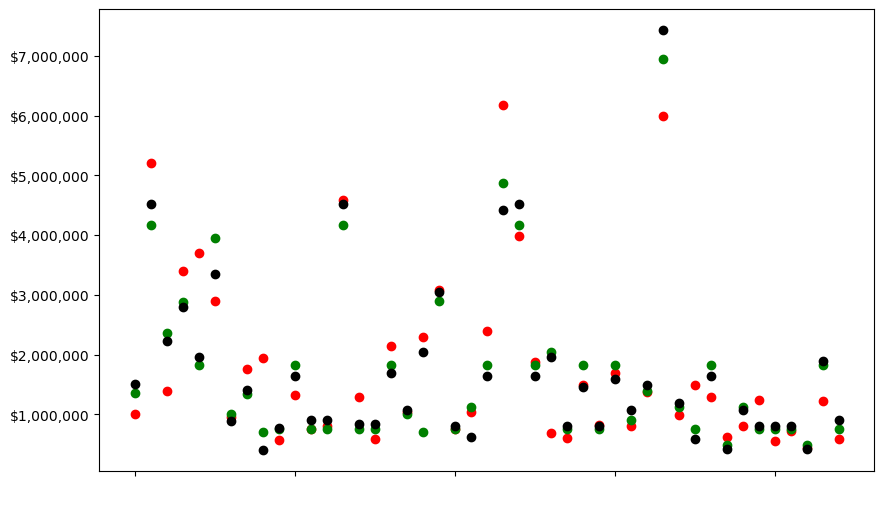

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="green")
plt.scatter(knn_bp_predict_df.index,knn_bp_predict_df["prediction"], color="black")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [18]:
knn_bp_predict_df.sort_values(by='prediction', inplace=True)
knn_bp_predict_df.reset_index(inplace=True)

knn_sfs_predict_df.sort_values(by='prediction', inplace=True)
knn_sfs_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Sequential Feature Selection, and Test Data.

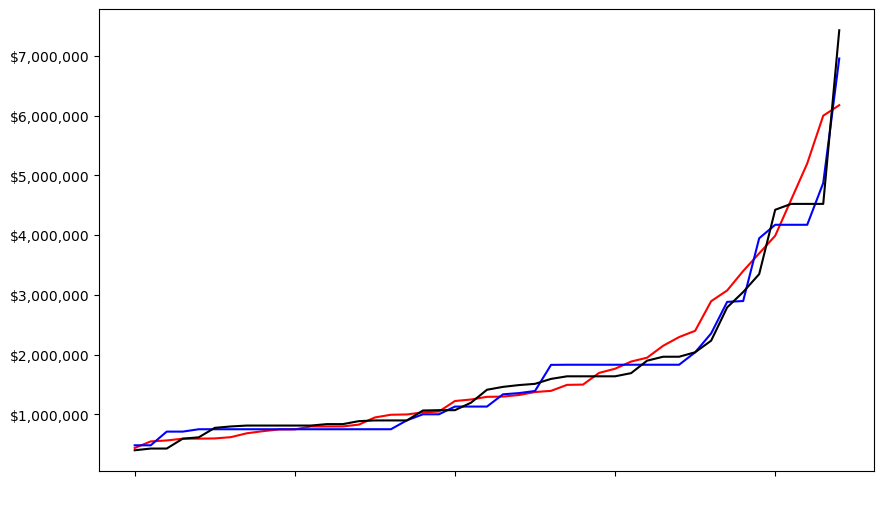

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="blue")
plt.plot(knn_bp_predict_df.index,knn_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [20]:
results_dict

{'model': ['KNN Best Params', 'Sequential Feature Selector'],
 'explained variance score': ['0.810248470', '0.804406033'],
 'mae score': ['444,470.392593', '450,147.422222'],
 'mse score': ['402,898,591,288.911133', '416,996,986,572.533325'],
 'r2 score': ['0.809098', '0.802418'],
 'mean fit time': [0.0022185802459716796, 0.0015526771545410155]}

In [21]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
KNN Best Params,0.810248470,"444,470.392593","402,898,591,288.911133",0.809098,0.002219
Sequential Feature Selector,0.804406033,"450,147.422222","416,996,986,572.533325",0.802418,0.001553
